# SnowMaL pipeline

In [65]:
import os, glob
import matplotlib.pyplot as plt
import datetime
import rioxarray as rxr
import xarray as xr
import yaml
from TopoPyScale import topoclass as tc
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

## Define paths in directory and settings

In [2]:
# Site name
site_name = 'MCS'
# Snow depth date
sd_date = '2024-03-15'
# Path to the snowmal code repository
snowmal_path = '/Users/raineyaberle/Research/PhD/SnowDEMs/snowmal'
# Path to reference DEM
dem_fn = '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/MCS/refdem/MCS_REFDEM_WGS84_5m.tif'
# Path to snow depth map
sd_fn = '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/MCS/lidar/20240315_MCS-snowdepth_RF_5m.tif'
# Output path
out_dir = '/Volumes/LaCie/raineyaberle/Research/PhD/SnowMaL/study-sites/MCS/'

## 1. Downscale ERA5 data to reference DEM using [TopoPyScale]()

## 2. Construct training data

In [33]:
# Load downscaled climate data
climate_fn = os.path.join(out_dir, '..', '..', 'outputs', 'output_daily.nc')
climate = xr.open_dataset(climate_fn)

# Load snow depth
sd = rxr.open_rasterio(sd_fn)

# Interpolate snow depth to climate coordinates
sd_interp = sd.sel(x=climate.x.data, y=climate.y.data, method='nearest')

# Add snow depth to climate dataset
climate['snow_depth'] = (('y', 'x'), sd_interp.data[0])

# Calculate cumulative positive degree days from air temperature
climate['pdd'] = xr.where(climate['t'] > 0, climate['t'], 0)
climate['pdd_cumsum'] = climate['pdd'].cumsum(dim='time')

# Calculate cumulative daily precipitation
climate['tp_cumsum'] = climate['tp'].cumsum(dim='time')

# Select the date of the snow depth measurement
sd_dt = np.datetime64(f'{sd_date}T00:00:00')
training_data_xr = climate.sel(time=sd_dt, method='nearest')
training_data_xr

<xarray.Dataset>
Dimensions:         (y: 1681, x: 1574)
Coordinates:
    point_name      (y, x) object '090' '090' '090' '090' ... '004' '004' '004'
    reference_time  datetime64[ns] 2023-10-01
  * x               (x) float64 6.016e+05 6.016e+05 ... 6.094e+05 6.094e+05
  * y               (y) float64 4.871e+06 4.871e+06 ... 4.862e+06 4.862e+06
    time            datetime64[ns] 2024-03-15
Data variables:
    t               (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    tp              (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    elevation       (y, x) float64 ...
    slope           (y, x) float64 ...
    aspect          (y, x) float64 ...
    svf             (y, x) float64 ...
    spatial_ref     int64 ...
    snow_depth      (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    pdd             (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pdd_cumsum      (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tp_cumsum       (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [123]:
# Define feature columns and labels
feature_cols = ['elevation', 'slope', 'aspect', 'svf', 'pdd_cumsum', 'tp_cumsum']
labels = ['snow_depth']

# Restructure raster into DataFrame of all point values
training_data = pd.DataFrame()
for col in feature_cols:
    df = pd.DataFrame({col: np.ravel(training_data_xr[col].data)})
    training_data = pd.concat([training_data, df], axis=1)
for col in labels:
    df = pd.DataFrame({col: np.ravel(training_data_xr[col].data)})
    training_data = pd.concat([training_data, df], axis=1)    

# Save indices of rows with all real values (no NaNs allowed in classification)
ireal = np.argwhere(training_data.isna().any(axis=1).values == False)
training_data.dropna(inplace=True)
training_data


,elevation,slope,aspect,svf,pdd_cumsum,tp_cumsum,snow_depth
5682,2100.215495,0.262926,2.610305,0.981346,369.371857,721.889429,2.114892
5683,2100.215495,0.270494,2.548886,0.980369,369.371857,721.889429,2.117519
5684,2099.333881,0.281847,2.419906,0.978414,369.371857,721.889429,2.126809
5685,2098.452268,0.271755,2.321636,0.980369,369.371857,721.889429,2.116928
5686,2096.689041,0.247789,2.247933,0.983301,369.371857,721.889429,2.092038
...,...,...,...,...,...,...,...
2640300,1645.303044,0.531602,6.055907,0.925632,611.619678,522.528683,0.964037
2640301,1646.184658,0.513942,6.215597,0.931497,611.619678,522.528683,0.761653
2640302,1646.184658,0.505112,0.085987,0.933452,611.619678,522.528683,0.673868
2640303,1645.303044,0.520249,0.245676,0.931497,611.619678,522.528683,1.008401


In [94]:
# Split into X and y
X = training_data[feature_cols]
y = training_data[labels]

# Scale feature columns
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X.values), columns=X.columns, index=X.index) 
X_scaled

,elevation,slope,aspect,svf,pdd_cumsum,tp_cumsum
0,0.133293,-0.885567,-0.188758,1.155120,-0.299298,0.080229
1,0.133293,-0.834239,-0.221260,1.137222,-0.299298,0.080229
2,0.129038,-0.757248,-0.289514,1.101425,-0.299298,0.080229
3,0.124783,-0.825685,-0.341518,1.137222,-0.299298,0.080229
4,0.116273,-0.988221,-0.380520,1.190917,-0.299298,0.080229
...,...,...,...,...,...,...
1369789,-2.062250,0.936556,1.634608,0.134907,2.592178,-1.909799
1369790,-2.057995,0.816792,1.719113,0.242298,2.592178,-1.909799
1369791,-2.057995,0.756910,-1.524593,0.278095,2.592178,-1.909799
1369792,-2.062250,0.859565,-1.440087,0.242298,2.592178,-1.909799


## 3. Develop machine learning models

In [95]:
# Fit model to input data
clf = RandomForestRegressor()
clf.fit(X_scaled, y)

RandomForestRegressor()

In [101]:
# Predict snow depth from training data
y_pred = clf.predict(X_scaled)

# Reshape to image coordinates
# y_pred_reshape = np.full(training_data_xr['elevation'].data.shape, np.nan)
# y_pred_reshape[ireal] = y_pred

# Calculate y - y_pred and plot
# difference = training_data_xr['snow_depth'].data - y_pred_reshape
# fig, ax = plt.subplots(1, 3, figsize=(12,5))
# for i, (data, cmap, title) in enumerate(list(zip(
#     [training_data_xr['snow_depth'].data, y_pred_reshape, difference],
#     ['Blues', 'Blues', 'coolwarm_r'],
#     ['Measured', 'Observed', 'Difference']))):
#     ax[i].imshow(data, cmap=cmap,
#                  extent=(np.min(training_data_xr.x.data), np.max(training_data_xr.x.data),
#                          np.min(training_data_xr.y.data), np.max(training_data_xr.y.data)))
#     ax[i].colorbar(shrink=0.8, label='Depth [m]')
#     ax[i].title(title)
# plt.show()

ValueError: shape mismatch: value array of shape (1369794,) could not be broadcast to indexing result of shape (1369794,1,1574)

In [121]:
training_data

,elevation,slope,aspect,svf,pdd_cumsum,tp_cumsum,snow_depth
0,2100.215495,0.262926,2.610305,0.981346,369.371857,721.889429,2.114892
1,2100.215495,0.270494,2.548886,0.980369,369.371857,721.889429,2.117519
2,2099.333881,0.281847,2.419906,0.978414,369.371857,721.889429,2.126809
3,2098.452268,0.271755,2.321636,0.980369,369.371857,721.889429,2.116928
4,2096.689041,0.247789,2.247933,0.983301,369.371857,721.889429,2.092038
...,...,...,...,...,...,...,...
1369789,1645.303044,0.531602,6.055907,0.925632,611.619678,522.528683,0.964037
1369790,1646.184658,0.513942,6.215597,0.931497,611.619678,522.528683,0.761653
1369791,1646.184658,0.505112,0.085987,0.933452,611.619678,522.528683,0.673868
1369792,1645.303044,0.520249,0.245676,0.931497,611.619678,522.528683,1.008401


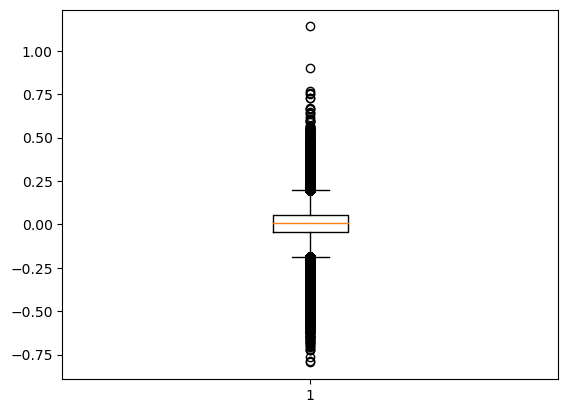

In [138]:
# y_pred_reshape = np.full(training_data_xr['elevation'].data.shape, np.nan)

plt.boxplot(np.ravel(y.values) - y_pred)
plt.show()

## 4. Construct snow depth predictions time series